### CT5133 Assignment 2: Transfer Learning, Convolutions, and Object Localisation in Keras

Aidan Tynan - 16394923

Luke Hayes - 

#### Import necessary libraries

In [1]:
#!pip install tensorflow
#!pip install keras

In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image

# Part 1: Dataset

The dataset chosen for this assignment was sourced from a classification competition created by Professor Hyoseok Hwang for his deep learning class in South Korea. It was created to improve deep learning and pytorch coding skills for students in his class where they were asked to code a classifier using pytorch.

The dataset consists of images of 4 different animals with 900 training and 100 validation images for each animal. The animals in the dataset are: cheetahs, tigers, jaguars and hyenas. As this assignment only required two classes, cheetah and tiger images were chosen as the datasets to be used.

The images have a shape of (400,400,3) with those numbers being height, width and rgb/colour values respectively. These images have to be resized to (224,224,3) for our model implementation to process them. There is a small amount of pre-processing applied to the data which will be discussed in part two.


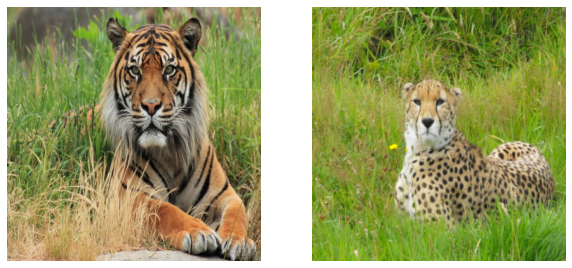

In [3]:
#Plot two example images
for i in range(1):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(Image.open('./validate/tiger_v/tiger_012_val_resized.jpg'))
    plt.axis("off")
    ax = plt.subplot(1, 2, 2)
    plt.imshow(Image.open('./validate/cheetah_v/cheetah_018_val_resized.jpg'))
    plt.axis("off")

### Import Datasets

In [2]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory('./train',image_size=(224,224), seed=42)

Found 1800 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('./validate',image_size=(224,224),seed=42)

Found 200 files belonging to 2 classes.


### Plot example images with binary labels

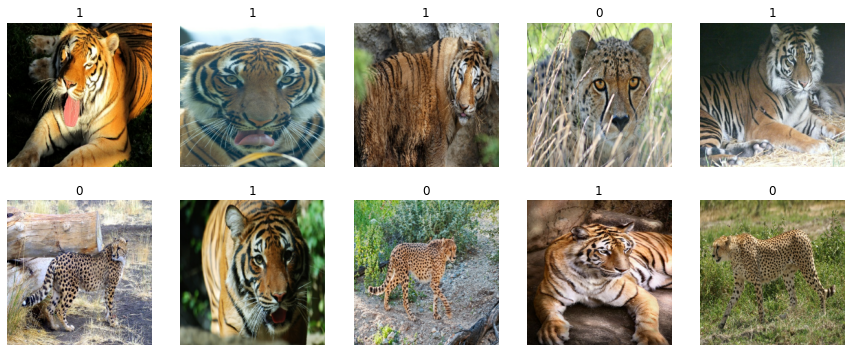

In [4]:
#Plot random example images from the resized dataset and title with their binary label, cheetah:(0), tiger:(1)
for image_demo in training_dataset.take(1):
    plt.figure(figsize=(15,6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(np.array(image_demo[0][i]).astype(int))
        plt.title(int(image_demo[1][i]))
        plt.axis("off")

Link to the dataset: https://www.kaggle.com/iluvchicken/cheetah-jaguar-and-tiger

# Part 2: Transfer Learning

The pre-trained image classification model chosen for this assignment was MobileNetV2 as it is small and can load weights from the training already performed on the imagenet data. The dense classification head was removed by setting the include_top variable to false when importing the model.

A pre-processing layer was created to to randomly flip images horizontally and rotate or zoom them slightly. Basic data 
augmentation techniques that have been proven to improve deep learning image classifiers <b>[1].</b>
A Normalization layer was required to normalize the inputs from the pre-processing layer. It normalizes them using the mean and standard deviation to put the values in the range (-1,1). Once the inputs are normalized they are passed to the base layer of the MobileNetV2 model with imagenet weights. A globabl average pooling layer is then added before finally adding a dense layer with two neurons that uses the softmax activation function to predict the two classes.

The model is created below and then trained and evaluated. The base model is frozen so only the added layers will be trained.
A simple input layer was added to reshape the data before entering the model, as well as a GlobalAveragePooling 2D and a softmax activated dense layer to make the predictions on the class labels. These additions can be seen in the base model below.

### Generate Base Model

In [10]:
batch_size = 32
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3), #Height,Width,Colour
    include_top=False, # Exclude Dense Classification head
)  
#Set base model so layers can't be trained
base_model.trainable = False

#Shape inputs
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model_example = keras.Model(inputs, outputs)

print("Base Model with GlobalAveragePooling 2D and a softmax activated dense layer")
model_example.summary()

Base Model with GlobalAveragePooling 2D and a softmax activated dense layer
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


From the model summary the mobilenet model's output can be seen which has a shape of (None, 7, 7, 1280). These represent the batch size, the channel height, and width and the channel index. These channels are feature maps that result from the convolution layers, activation functions and reducing performed in the base mobilenet model. The feauture maps are used to detect features in the images to make predictions or to detect objects to be passed to a classifier.

After 1 epoch of training with the dataset split into 57 batches of 16 the base model showed an accuracy of 79.5% when evaluated on unseen data, there is a relatively high amount of loss when compared to the models that do have pre-processing and normalisation.

### Add pre-processing & normalisation

To improve the performance of the model a data augmentation pre-processing layer was added before the base model. This layer randomly flips images horizontally and has a chance to zoom and rotate them slightly. More importantly a normalisation layer was required to normalise the inputs and significantly increase the accuracy of the model. This normalisation layers performs root mean square error normalisation and allows for colour intensity reduction within images to keep the weights and biases from growing too large. This can also help the network learn faster since the data for each colour channel is centered around the zero mean which can cause the gradients to act more uniformly and potentially improve performance of the model. Normalisation is important to reduce the effect of outliers and can help reduce the impact of brightness for example when classifying objects in photos taken during the day and during the night.

In [12]:
batch_size = 32
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3), #Height,Width,Colour
    include_top=False, # Exclude Dense Classification head
)  
#Set base model so layers can't be trained
base_model.trainable = False

#Create a layer to randomly flip images or to rotate/zoom slightly
preprocessing_improvement = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

# Add layers to be trained
inputs = keras.Input(shape=(224, 224, 3))
x = preprocessing_improvement(inputs)  # Apply random data augmentation

#Need to add a normalizing layer to put inputs in the range (-1,1), (from (0,255))
#Without normalizing accuracy ~60-70% with normalizing its ~95-99%
##outputs = (inputs - mean) / sqrt(variance)
normalization_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5]*3) #255/2
variance = mean * mean
x = normalization_layer(x)
normalization_layer.set_weights([mean, variance])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2562      
Total params: 2,260,553
Trainable params: 2,562
Non-trainable params: 2,257,991
________________________________________

### Train Model

The model training consists of compiling the model and then fitting it to the data. The number of epochs can be altered to potentially imporve performance. The model iterates over the images in batches of 32 and updates its weights and parameters to improve the accuracy of calculations.

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
epochs = 2
model.fit(training_dataset, epochs=epochs)

Epoch 1/2
57/57 [==============================] - 40s 699ms/step - loss: 0.3500 - sparse_categorical_accuracy: 0.9778
Epoch 2/2
57/57 [==============================] - 40s 701ms/step - loss: 0.3165 - sparse_categorical_accuracy: 0.9989


The model with pre-processing and data normalisation typically shows an accuracy over 97% after a single epoch and reductions in loss can be seen as the number of epochs increases up until the loss stabilizes.

### Evaluate Model on validation images

In [14]:
model.evaluate(validation_dataset)

7/7 [==============================] - 3s 453ms/step - loss: 0.3196 - sparse_categorical_accuracy: 0.9950


[0.3196011781692505, 0.9950000047683716]

The base model without the added pre-processing layers or its dense classification head showed an accuracy of 79.5% but had a large loss value of 0.5319 indicating that its predictions aren't confident and it is likely to have a greater disparity between it's prediction and the target to be predicted.

When the normalisation was added however the accuracy increased significantly to ~99.5% and the loss decreased to 0.3196. This model performed substantially better due to the added layers. The reduction in loss is significant and indicates that the models predictions are smaller in variance and closer to the target to be predicted.

See below for example predictions.

    [Cheetah    Tiger]


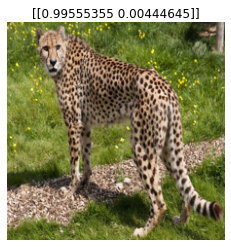

In [25]:
print("    [Cheetah    Tiger]")
for i in range(1):
    image = np.asarray(Image.open('./validate/cheetah_v/cheetah_001_val_resized.jpg').resize((224,224),3))
    cheetah_forPrediction = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
    title1 = model.predict(cheetah_forPrediction)
    plt.imshow(image)
    plt.title(title1)
    plt.axis("off")

     [Cheetah    Tiger]


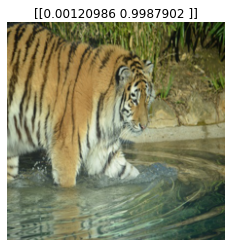

In [26]:
print("     [Cheetah    Tiger]")
for i in range(1):
    tiger = np.asarray(Image.open('./validate/tiger_v/tiger_007_val_resized.jpg').resize((224,224),3))
    tiger_forPrediction = np.reshape(tiger,(1,tiger.shape[0],tiger.shape[1],tiger.shape[2]))
    title2 = model.predict(tiger_forPrediction)
    plt.imshow(tiger)
    plt.title(title2)
    plt.axis("off")

One caveat of the accuracy of the model is that it was evaluated on a validation set of only 200 images, 100 for each class and as such further validation would likely be required on a larger dataset to prove it's accuracy.

# Part 3 Inspecting Convolutional Features

<b> Placeholder textbox to describe what needs to be done </b>

Description of how base model was investigated, e.g. how we got the scalar outputs from the model using pooling and softmax and then getting the indexes and how we added the top 3 correlated softmax values for each image in each animals training dataset. How all of those top 3s were aggregated and the top nodes were chosen. Talk about the weak class detectors we found, how some of them appear for both classes, maybe a sentence on why they appear for both classes and what could likely cause it, e.g. similar features like a nose or something idk. 


<b> Specify method, state results and briefly interpret </b>



In [254]:
#Base model with global pooling and a softmax layer.
global_pooling = keras.layers.GlobalAveragePooling2D()
softmax_layer = keras.layers.Softmax()
neuronSearch = keras.Sequential(
    [
        base_model,
        global_pooling,
        softmax_layer        
    ]
)
neuronSearch.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
softmax_2 (Softmax)          (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
import os
notebook_path = os.path.abspath("DeepLearningAssignment2.ipynb")

In [33]:
#OKAY SO BASICALLY HERE WE WANT TO CREATE A FUNCTION THAT 
#TAKES IN AN IMAGE OR SET OF IMAGES
#USING THE SOFTMAX LAYER WE WANT TO EXTRACT THE THE TOP 3 NEURONS AND THEN ADD THEM TO A DICTIONARY WITH THE 
#NUMBER OF TIMES THAT NEURON HAS SHOWED AS BEING IMPORTANT FOR ALL THE IMAGES
#THEN WE WILL SELECT THE TOP N AS THE MOST IMPORTANT 
def interesting_neurons(animal, N):
    
    #FILE PATH WE WILL USE WILL DEPEND ON THE ANIMAL 
    if animal == "cheetah":
        path = './train/cheetah/'
    elif animal == "tiger":
        path = './train/tiger/'

    #CREATE A BLANK DICTIONARY SO WE CAN ADD THE NEURON AND THE NUMBER OF TIMES IT HAS APPEARED
    neuron_dict = {}
    
    for filename in os.listdir(path):
        #print(filename)
        image = np.asarray(Image.open(path + filename).resize((224,224),3))
        img_forPrediction = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
        img_array = neuronSearch.predict(img_forPrediction)
        neurons = sorted(range(len(img_array[0])), key = lambda sub: img_array[0][sub])[-N:]
        #print(neurons)
        
        #NOW LOOP THROUGH THE RESULTS AND APPEND TO THE DICTIONARY 
        #ADD IF NEW OR INCREMENT IF NOT NEW 
        
        for neur in neurons:
            if neur in neuron_dict:
                neuron_dict[neur] += 1
                #print("incrementing")
            else:
                neuron_dict[neur] = 1
                #print("adding")
    return neuron_dict
        
#GET THE INTERESTING       
cheetah_dict = interesting_neurons("cheetah", 3)       
tiger_dict = interesting_neurons("tiger", 3)

#NOW LETS GET THE TOP 5 OF EACH 
cheetah_keys = sorted(cheetah_dict, key=cheetah_dict.get, reverse=True)[:5]
tiger_keys = sorted(tiger_dict, key=tiger_dict.get, reverse=True)[:5]


print(cheetah_keys)
print(tiger_keys)


[522, 1241, 587, 511, 90]
[522, 1241, 587, 511, 54]


In [120]:
#cheetah_dict 
#Neurons and their counts of being in the softmax top 3 for all 900 images of the training dataset
# (522: 854), (1241: 514), (587: 191), (511: 176), (90: 163)
# ~95%, 57%, 21%, 19.5%, 18%

#tiger_dict
#Neurons and their counts of being in the softmax top 3 for all 900 images of the training dataset
# (522: 843), (1241: 429), (587: 423), (511: 275), (54: 237)

# Part 4: Object Localization

In [57]:
#using interesting channels obtained from part 3 (Examples for cheetah 515, 511, 14)
#visualize 2d output
#comment on if it coould allow localisation of objects in the input image.
#several examples and corresponding 2d outputs.
base_model.layers[153].output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

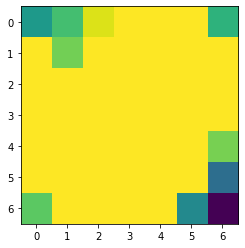

In [124]:
last_layer = len(base_model.layers) - 1

prediction_tensor = base_model.predict(tiger_forPrediction)
prediction_tensor
plt.imshow(prediction_tensor[0,:,:,511])

<b>[1]</b>  Shorten, C., Khoshgoftaar, T.M. A survey on Image Data Augmentation for Deep Learning. J Big Data 6, 60 (2019). 
https://doi.org/10.1186/s40537-019-0197-0